# Lung and Colon Cancer Classification
## About Dataset
This dataset contains 25,000 histopathological images with 5 classes. All images are 768 x 768 pixels in size and are in jpeg file format.
The images were generated from an original sample of HIPAA compliant and validated sources, consisting of 750 total images of lung tissue (250 benign lung tissue, 250 lung adenocarcinomas, and 250 lung squamous cell carcinomas) and 500 total images of colon tissue (250 benign colon tissue and 250 colon adenocarcinomas) and augmented to 25,000 using the Augmentor package.
There are five classes in the dataset, each with 5,000 images, being:

* Lung benign tissue
* Lung adenocarcinoma
* Lung squamous cell carcinoma
* Colon adenocarcinoma
* Colon benign tissue


How to Cite this Dataset
If you use in your research, please credit the author of the dataset:

Original Article
Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

Relevant Links
https://arxiv.org/abs/1912.12142v1
https://github.com/tampapath/lung_colon_image_set
Dataset BibTeX
@article{,
title= {LC25000 Lung and colon histopathological image dataset},
keywords= {cancer,histopathology},
author= {Andrew A. Borkowski, Marilyn M. Bui, L. Brannon Thomas, Catherine P. Wilson, Lauren A. DeLand, Stephen M. Mastorides},
url= {https://github.com/tampapath/lung_colon_image_set}
}


## Imports

In [ ]:
import os

import pyrootutils

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

if os.getenv("DATA_ROOT") is None:
    os.environ["DATA_ROOT"] = f"{root}/datasets"

In [17]:
import glob
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
from hydra import compose, initialize
from torchvision.datasets import ImageFolder

## Download datasets

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base="1.2", config_path="../configs"):
    cfg = compose(config_name="train")
    print(cfg.paths.train_dir)

datasets/train/


In [20]:
DATASET_DIR = Path(root) / cfg.data.dataset_dir

In [21]:
DATASET_DIR.mkdir(exist_ok=True)
if len(list(DATASET_DIR.iterdir())) == 0:
    # Download the dataset
    od.download(dataset_id_or_url=cfg.data.dataset_url, data_dir=str(DATASET_DIR))

## Loading Images

In [22]:
CLASS_NAMES = [
    "colon-adenocarcinoma",
    "colon-benign-tissue",
    "lung-adenocarcinoma",
    "lung-benign-tissue",
    "lung-squamous-cell-carcinoma",
]

class_mapping = dict(zip(range(len(CLASS_NAMES)), CLASS_NAMES, strict=False))
class_mapping

{0: 'colon-adenocarcinoma',
 1: 'colon-benign-tissue',
 2: 'lung-adenocarcinoma',
 3: 'lung-benign-tissue',
 4: 'lung-squamous-cell-carcinoma'}

In [23]:
cfg.paths.train_dir

'datasets/train/'

In [24]:
DATASET_DIR = Path(root) / cfg.data.dataset_dir / cfg.data.dataset_name

TRAIN_IMAGE_DIR = Path(root) / cfg.paths.train_dir
VALID_IMAGE_DIR = Path(root) / cfg.paths.validation_dir
TEST_DIR = Path(root) / cfg.paths.test_dir
DATASET_DIR

PosixPath('/home/ultron/AI/practice-projects/CV/bone-fracture-detection-pytorch/datasets/lung-and-colon-cancer-histopathological-images')

## Loading Images

In [25]:
datasets = ImageFolder(
    root=str(DATASET_DIR),
    transform=None,
    target_transform=None,
    is_valid_file=None,
)
print(f"Number of images in the dataset: {len(datasets)}")

Number of images in the dataset: 25000


In [26]:
datasets.class_to_idx

{'colon-adenocarcinoma': 0,
 'colon-benign-tissue': 1,
 'lung-adenocarcinoma': 2,
 'lung-benign-tissue': 3,
 'lung-squamous-cell-carcinoma': 4}

In [27]:
import random

IMAGE_NUM = 9
random_range = random.sample(range(0, len(datasets)), IMAGE_NUM)
random_range

[21605, 11749, 5181, 7666, 11783, 1198, 19131, 5288, 16308]

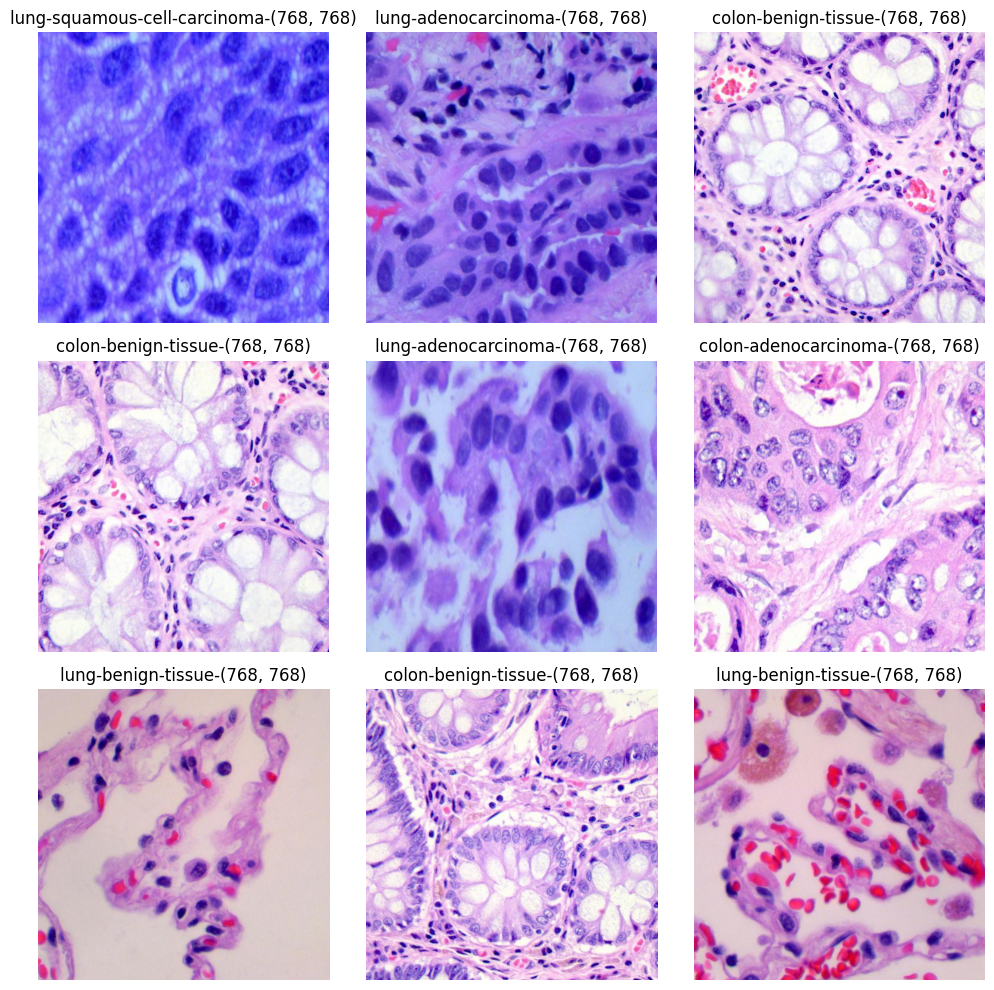

In [28]:
plt.figure(figsize=(10, 10))

for i, idx in enumerate(random_range):
    plt.subplot(3, 3, i + 1)
    img = datasets[idx][0]
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"{datasets.classes[datasets[idx][1]]}-{img.size}")  # datasets.classes[label])
plt.tight_layout()
plt.show()

In [29]:
import torch
from torchvision.transforms import v2

transforms = v2.Compose(
    [
        v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.RandomRotation(degrees=(-15, 15)),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        v2.ToDtype(torch.float32, scale=True),
    ]
)
del datasets

In [30]:
datasets = ImageFolder(
    root=str(DATASET_DIR),
    transform=transforms,
    target_transform=None,
    is_valid_file=None,
)

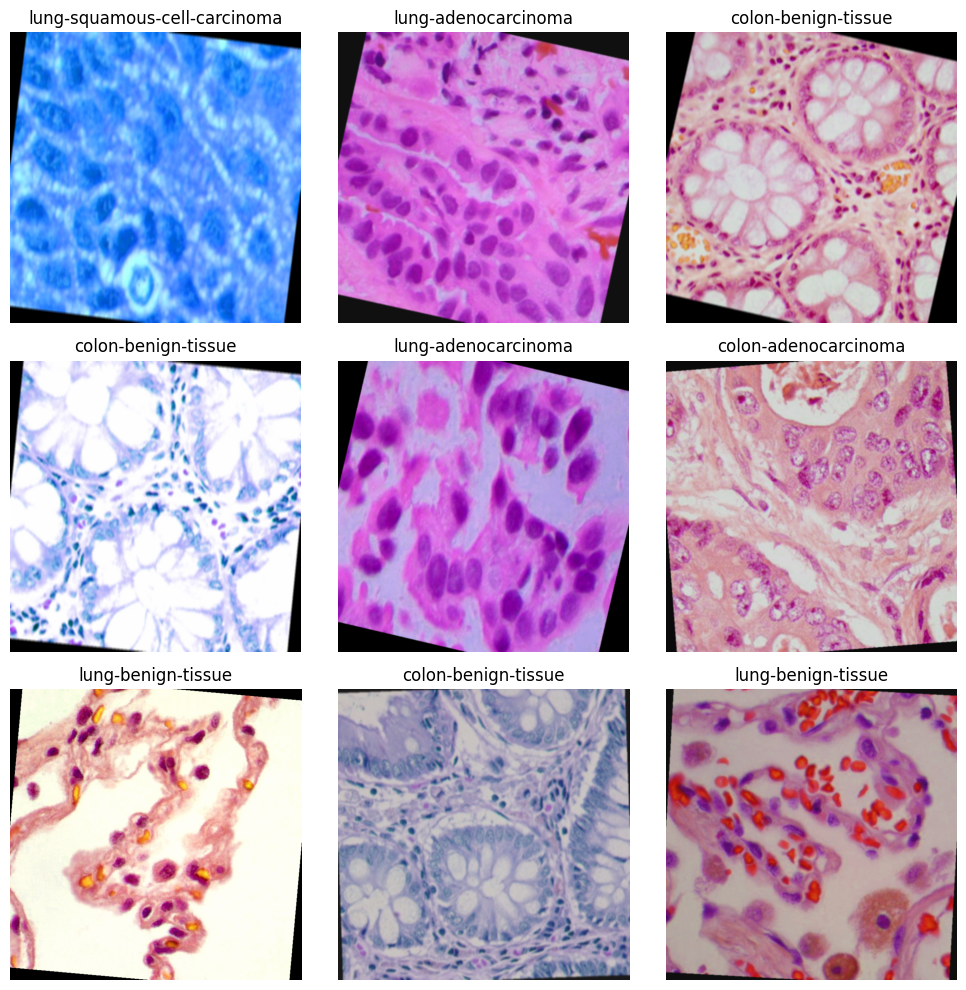

In [31]:
plt.figure(figsize=(10, 10))

for i, idx in enumerate(random_range):
    plt.subplot(3, 3, i + 1)
    img = datasets[idx][0]
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
    plt.axis("off")
    plt.title(f"{datasets.classes[datasets[idx][1]]}")  # datasets.classes[label])
plt.tight_layout()
plt.show()

In [32]:
del datasets

## Train, Validatin, Split

In [ ]:
class_name = []
for _dir in list(DATASET_DIR.iterdir()):
    class_name.append(_dir.name)

lung-squamous-cell-carcinoma
lung-benign-tissue
lung-adenocarcinoma
colon-benign-tissue
colon-adenocarcinoma


In [38]:
from collections import defaultdict

datasets = defaultdict(list)
for class_dir_path in list(DATASET_DIR.iterdir()):
    for file_path in class_dir_path.iterdir():
        datasets[class_dir_path.name].append(file_path)

datasets

defaultdict(list,
            {'lung-squamous-cell-carcinoma': [PosixPath('/home/ultron/AI/practice-projects/CV/bone-fracture-detection-pytorch/datasets/lung-and-colon-cancer-histopathological-images/lung-squamous-cell-carcinoma/lungscc3920.jpeg'),
              PosixPath('/home/ultron/AI/practice-projects/CV/bone-fracture-detection-pytorch/datasets/lung-and-colon-cancer-histopathological-images/lung-squamous-cell-carcinoma/lungscc1241.jpeg'),
              PosixPath('/home/ultron/AI/practice-projects/CV/bone-fracture-detection-pytorch/datasets/lung-and-colon-cancer-histopathological-images/lung-squamous-cell-carcinoma/lungscc2692.jpeg'),
              PosixPath('/home/ultron/AI/practice-projects/CV/bone-fracture-detection-pytorch/datasets/lung-and-colon-cancer-histopathological-images/lung-squamous-cell-carcinoma/lungscc3224.jpeg'),
              PosixPath('/home/ultron/AI/practice-projects/CV/bone-fracture-detection-pytorch/datasets/lung-and-colon-cancer-histopathological-images/lung

In [39]:
import pandas as pd

df = pd.DataFrame(datasets)
df.head()

lung-squamous-cell-carcinoma  \
0  /home/ultron/AI/practice-projects/CV/bone-frac...   
1  /home/ultron/AI/practice-projects/CV/bone-frac...   
2  /home/ultron/AI/practice-projects/CV/bone-frac...   
3  /home/ultron/AI/practice-projects/CV/bone-frac...   
4  /home/ultron/AI/practice-projects/CV/bone-frac...   

                                  lung-benign-tissue  \
0  /home/ultron/AI/practice-projects/CV/bone-frac...   
1  /home/ultron/AI/practice-projects/CV/bone-frac...   
2  /home/ultron/AI/practice-projects/CV/bone-frac...   
3  /home/ultron/AI/practice-projects/CV/bone-frac...   
4  /home/ultron/AI/practice-projects/CV/bone-frac...   

                                 lung-adenocarcinoma  \
0  /home/ultron/AI/practice-projects/CV/bone-frac...   
1  /home/ultron/AI/practice-projects/CV/bone-frac...   
2  /home/ultron/AI/practice-projects/CV/bone-frac...   
3  /home/ultron/AI/practice-projects/CV/bone-frac...   
4  /home/ultron/AI/practice-projects/CV/bone-frac...   

                                 colon-benign-tissue  \
0  /home/ultron/AI/practice-projects/CV/bone-frac...   
1  /home/ultron/AI/practice-projects/CV/bone-frac...   
2  /home/ultron/AI/practice-projects/CV/bone-frac...   
3  /home/ultron/AI/practice-projects/CV/bone-frac...   
4  /home/ultron/AI/practice-projects/CV/bone-frac...   

                                colon-adenocarcinoma  
0  /home/ultron/AI/practice-projects/CV/bone-frac...  
1  /home/ultron/AI/practice-projects/CV/bone-frac...  
2  /home/ultron/AI/practice-projects/CV/bone-frac...  
3  /home/ultron/AI/practice-projects/CV/bone-frac...  
4  /home/ultron/AI/practice-projects/CV/bone-frac...

In [ ]:
from sklearn.model_selection import train_test_split

train_ds, test_ds = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    shuffle=True,
)
train_ds, val_ds = train_test_split(
    train_ds,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

In [44]:
DATASET_DIR

PosixPath('/home/ultron/AI/practice-projects/CV/bone-fracture-detection-pytorch/datasets/lung-and-colon-cancer-histopathological-images')

In [47]:
cfg.paths.train_dir

'datasets/train/'

In [55]:
def create_dataset_dir(dataset_split_dir: Path, dataset_df: pd.DataFrame) -> None:
    dataset_split_dir.mkdir(parents=True, exist_ok=True)
    for dir_name in dataset_df.columns:
        os.makedirs(dataset_split_dir / dir_name, exist_ok=True)
        for file_path in dataset_df[dir_name]:
            file_name = file_path.name
            new_file_path = dataset_split_dir / dir_name / file_name
            if not new_file_path.exists():
                os.symlink(file_path, new_file_path)

In [57]:
train_dir = Path(root) / cfg.paths.train_dir
create_dataset_dir(dataset_split_dir=train_dir, dataset_df=train_ds)  # dataset_split_dir: Path, dataset_df: pd.DataFrame)

In [58]:
valid_dir = Path(root) / cfg.paths.validation_dir
create_dataset_dir(dataset_split_dir=valid_dir, dataset_df=val_ds)  # dataset_split_dir: Path, dataset_df: pd.DataFrame)

test_dir = Path(root) / cfg.paths.test_dir
create_dataset_dir(dataset_split_dir=test_dir, dataset_df=test_ds)  # dataset_split_dir: Path, dataset_df: pd.DataFrame)